In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
from sympy import solve

from PIL import Image

In [2]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.imshow(im)
    plt.show()
    print('Set at least %d lines to compute vanishing point' % min_lines)
    while True:
        print('Click the two endpoints, use the right key to undo, and use the middle key to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print('Need at least %d lines, you have %d now' % (min_lines, n))
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [3]:
def plot_lines_and_vp(im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10

    plt.figure()
    plt.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    plt.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    plt.show()

In [4]:
def get_top_and_bottom_coordinates(im, obj):
    """
    For a specific object, prompts user to record the top coordinate and the bottom coordinate in the image.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        obj: string, object name
    Returns:
        coord: np.ndarray of shape (3, 2)
            where coord[:, 0] is the homogeneous coordinate of the top of the object and coord[:, 1] is the homogeneous
            coordinate of the bottom
    """
    plt.figure()
    plt.imshow(im)

    print('Click on the top coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x1, y1 = clicked[0]
    # Uncomment this line to enable a vertical line to help align the two coordinates
    # plt.plot([x1, x1], [0, im.shape[0]], 'b')
    print('Click on the bottom coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x2, y2 = clicked[0]

    plt.plot([x1, x2], [y1, y2], 'b')

    return np.array([[x1, x2], [y1, y2], [1, 1]])

In [5]:
def get_vanishing_point(lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    second_moment = lines.dot(lines.T)
    w, v = np.linalg.eig(second_moment)
    # Find min eigenvalue and eigen vec.
    min_idx = np.argmin(w)
    vp = v[:, min_idx]
    # Convert to homogeneous.
    vp = vp / vp[-1]
    return vp

In [6]:
def get_horizon_line(vps):
    """
    Calculates the ground horizon line.
    """
    pt1 = vps[:, 0]
    pt2 = vps[:, 1]
    
    # Line equation: line[0] * x + line[1] * y + line[2] = 0
    horizon_line = np.cross(pt1, pt2)
    
    # Normalize.
    scale = np.sqrt(horizon_line[0]**2 + horizon_line[1]**2)
    horizon_line = horizon_line / scale
    
    return horizon_line

In [7]:
def plot_horizon_line(im, horizon_line):
    """
    Plots the horizon line.
    """
    x_range = im.shape[1]
    x = np.arange(x_range)
    y = (- horizon_line[2] - horizon_line[0] * x) / horizon_line[1]
    
    plt.figure()
    plt.imshow(im)
    plt.plot(x, y, 'r', linestyle='-', linewidth=3)    
    plt.show()

In [8]:
def get_camera_parameters(vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    vp1 = vpts[:, 0][:, np.newaxis]  # column vector
    vp2 = vpts[:, 1][:, np.newaxis]
    vp3 = vpts[:, 2][:, np.newaxis]
    
    f, px, py= symbols('f, px, py')
    K_inv_T = Matrix([[1/f, 0, 0], [0, 1/f, 0], [-px/f, -py/f, 1]])
    K_inv = Matrix([[1/f, 0, -px/f], [0, 1/f, -py/f], [0, 0, 1]])
    
    eq1 = vp1.T * K_inv_T * K_inv * vp2
    eq2 = vp1.T * K_inv_T * K_inv * vp3
    eq3 = vp2.T * K_inv_T * K_inv * vp3
    
    f, px, py = solve([eq1[0], eq2[0], eq3[0]], (f, px, py))[0]

    return abs(f), px, py

In [9]:
def get_rotation_matrix(vpts, f, u, v):
    """
    Computes the rotation matrix using the camera parameters.
    """
    Z = vpts[:, 0][:, np.newaxis]  # column vector
    X = vpts[:, 1][:, np.newaxis]
    Y = vpts[:, 2][:, np.newaxis]

    K = np.array([[f, 0, u], [0, f, v], [0, 0, 1]]).astype(np.float)
    K_inv = np.linalg.inv(K)

    r1 = K_inv.dot(X)
    r2 = K_inv.dot(Y)
    r3 = K_inv.dot(Z)

    # Normalize.
    r1 = r1 / np.linalg.norm(r1)
    r2 = r2 / np.linalg.norm(r2)
    r3 = r3 / np.linalg.norm(r3)

    R = np.concatenate((r1, r2, r3), axis=1)
       
    return R

In [10]:
def estimate_height(im, person_coord, obj_coord, horizon_line,vpts):
    """
    Estimates height for a specific object using the recorded coordinates. You might need to plot additional images here for
    your report.
    """
    H = 1.6764  # 5ft 6in to meters
    # H = 1.8288  # 6 ft to meters
    
    vpz = vpts[:, 2]  # Vertical vp.
    # Person as reference.
    t0 = person_coord[:, 0]
    b0 = person_coord[:, 1]

    # Obj coords.
    r = obj_coord[:, 0]
    b = obj_coord[:, 1]

    line_b0_b = np.cross(b0, b)
    v = np.cross(line_b0_b, horizon_line)
    v = v / v[-1]
    
    line_v_t0 = np.cross(v, t0)
    line_r_b = np.cross(r, b)
    t = np.cross(line_v_t0, line_r_b)
    t = t / t[-1]
    
    height = H*(np.linalg.norm(r-b) * np.linalg.norm(vpz-t) /
              np.linalg.norm(t-b) / np.linalg.norm(vpz-r))
    
    # Plot the lines used for measuring height.
    plt.figure()
    plt.imshow(im)
    plt.plot([t0[0], b0[0]], [t0[1], b0[1]], 'b', linestyle='-', linewidth=1.5)
    plt.plot([b[0], b0[0]], [b[1], b0[1]], 'g', linestyle='-', linewidth=1)
    plt.plot([t0[0], t[0]], [t0[1], t[1]], 'g', linestyle='-', linewidth=1)
    plt.plot(t[0], t[1], 'g', marker='+')
    plt.plot(b[0], b[1], 'g', marker='+')
    plt.plot([r[0], b[0]], [r[1], b[1]], 'r', linestyle='-', linewidth=1.5)
    
    x_range = im.shape[1]
    x = np.arange(x_range)
    y = (- horizon_line[2] - horizon_line[0] * x) / horizon_line[1]
    plt.plot(x, y, 'r', linestyle='-', linewidth=1)   
    
    plt.plot([b[0], v[0]], [b[1], v[1]], 'g', linestyle='-', linewidth=1)
    plt.plot([t[0], v[0]], [t[1], v[1]], 'g', linestyle='-', linewidth=1)
    plt.plot(v[0], v[1], 'g', marker='o', markersize=2.5)
    
    plt.show()
    
    return height

Getting vanishing point 0


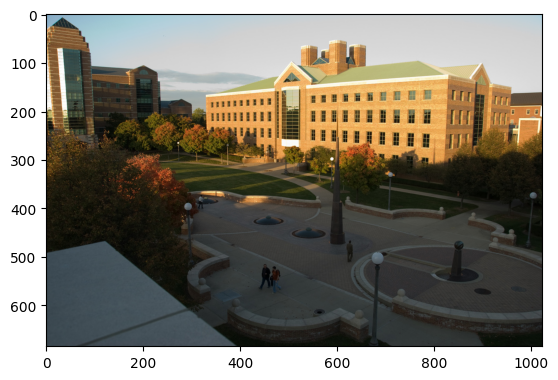

Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input


C:\Users\derek\AppData\Local\Temp\ipykernel_3944\3088310108.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  clicked = plt.ginput(2, timeout=0, show_clicks=True)


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [11]:
im = np.asarray(Image.open('C:/Users/derek/Documents/GitHub/myCode/CS543_CV/Lab4_view_geometry/data/CSL.jpg'))

# Part 1
# Get vanishing points for each of the directions
num_vpts = 3
vpts = np.zeros((3, num_vpts))
for i in range(num_vpts):
    print('Getting vanishing point %d' % i)
    # Get at least three lines from user input
    n, lines, centers = get_input_lines(im)
    # <YOUR IMPLEMENTATION> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(lines)
    # Plot the lines and the vanishing point
    plot_lines_and_vp(im, lines, vpts[:, i])

# <YOUR IMPLEMENTATION> Get the ground horizon line
horizon_line = get_horizon_line(vpts)
# <YOUR IMPLEMENTATION> Plot the ground horizon line
plot_horizon_line(im, horizon_line)

# Part 2
# <YOUR IMPLEMENTATION> Solve for the camera parameters (f, u, v)
f, u, v = get_camera_parameters(vpts)

# Part 3
# <YOUR IMPLEMENTATION> Solve for the rotation matrix
R = get_rotation_matrix(vpts, f, u, v)

# Part 4
# Record image coordinates for each object and store in map
objects = ('person', 'CSL building', 'the spike statue', 'the lamp posts')
coords = dict()
for obj in objects:
    coords[obj] = get_top_and_bottom_coordinates(im, obj)

# <YOUR IMPLEMENTATION> Estimate heights
for obj in objects[1:]:
    print('Estimating height of %s' % obj)
    height = estimate_height(im, coords['person'], coords[obj], horizon_line)
